In [187]:
from helpers_merging import *

initial_power = 50* si.uW
initial_waist = 1.1*si.uW
initial_distance = 3*si.um

trap: DoubleTweezer = DoubleTweezer(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0*si.G/si.cm,
    grad_r=0,
    power_tweezer1 = initial_power,     #stationary
    power_tweezer2 = initial_power*1.18,     #transfer tweezer
    waist_tweezer1 = initial_waist,     #stationary
    waist_tweezer2 = initial_waist,     #transfer tweezer
    distance_tweezers = initial_distance,

    a=180*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),
    wvl = 532 * si.nm,

    g = 0,
)

x, y, z = trap.x, trap.y, trap.z



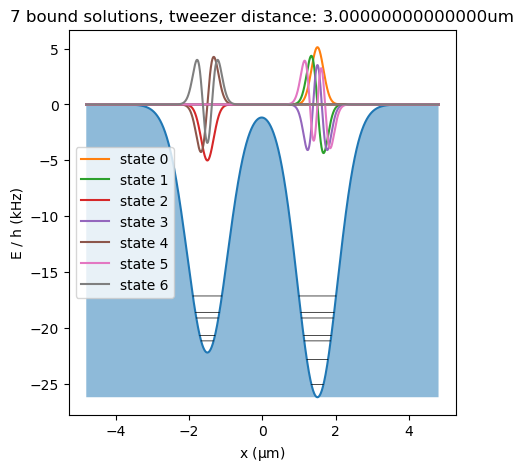

In [188]:
left_cutoff = -0.5*initial_distance-3*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
right_cutoff = 0.5*initial_distance+3*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])

trap[trap.distance_tweezers] = initial_distance
plot_solutions(trap,7,left_cutoff,right_cutoff,display_plot=-1,state_mult=40,n_pot_steps=2000,plot=True,ret_results=False)

In [194]:
distances = np.linspace(initial_distance,0*si.um,500)
energies, states, potentials = loop_distances(trap, distances,n_levels=10)

In [195]:
index_top = find_crossovers_topstate(energies)

In [196]:
index, swap_index = find_crossovers(energies)

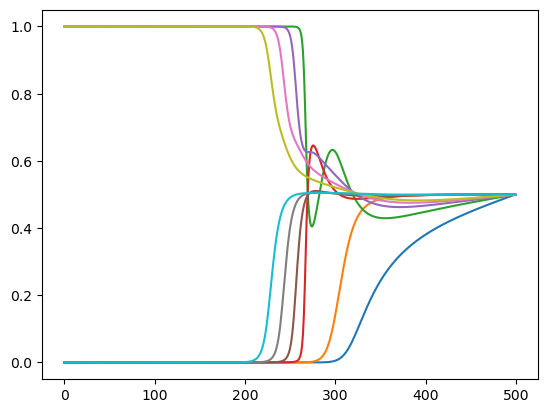

In [197]:
prob_left = np.sum(states[:,:,:int(len(states[0,0])/2)]**2,axis=2)
diff = np.abs(np.gradient(prob_left,axis=0))
plt.plot(prob_left)

In [174]:
"""n_levels = len(energies[0,:])
index = np.array([],dtype=int)
swap_index =np.empty((0,2),dtype=int)
                    
for i in range(n_levels):
    for j in range(i+1,n_levels):
        diff = np.abs(energies[:,i] - energies[:,j])
        plt.plot(-diff)
        #mask = np.where(diff < 5e-2*(np.max(diff)-np.min(diff)),diff,5e-2*(np.max(diff)-np.min(diff)))
        #plt.plot(mask,color="k")
        peaks = find_peaks(-diff,height=(-1e-33,0))[0]
        index = np.append(index,peaks)
        for k in range(len(peaks)):
            swap_index = np.append(swap_index,[[i,j]],axis=0)"""

'n_levels = len(energies[0,:])\nindex = np.array([],dtype=int)\nswap_index =np.empty((0,2),dtype=int)\n                    \nfor i in range(n_levels):\n    for j in range(i+1,n_levels):\n        diff = np.abs(energies[:,i] - energies[:,j])\n        plt.plot(-diff)\n        #mask = np.where(diff < 5e-2*(np.max(diff)-np.min(diff)),diff,5e-2*(np.max(diff)-np.min(diff)))\n        #plt.plot(mask,color="k")\n        peaks = find_peaks(-diff,height=(-1e-33,0))[0]\n        index = np.append(index,peaks)\n        for k in range(len(peaks)):\n            swap_index = np.append(swap_index,[[i,j]],axis=0)'

In [175]:
print(index_top)
print(index)
print(swap_index)

[17 24 29 34 37 43]
[359 351 342]
[[2 3]
 [4 5]
 [6 7]]


In [176]:
"""arr = np.abs(np.gradient(np.gradient(energies[:,-1])))
plt.plot(arr)
index = find_peaks(arr,width=(1,4))[0]
for i,ind in enumerate(index):
    plt.axvline(ind,color="k",alpha=0.7)"""

'arr = np.abs(np.gradient(np.gradient(energies[:,-1])))\nplt.plot(arr)\nindex = find_peaks(arr,width=(1,4))[0]\nfor i,ind in enumerate(index):\n    plt.axvline(ind,color="k",alpha=0.7)'

In [177]:
new_energies = np.full((energies.shape[0],energies.shape[1]+len(index_top)),np.nan)
new_states = np.full((states.shape[0],states.shape[1]+len(index_top),states.shape[2]),np.nan)

swapped_index = np.arange(0,energies.shape[1])
for i, dist in enumerate(distances): 
    if np.any(i == index):
        j = np.where(index == i)
        swapped_index[swap_index[j]] = swapped_index[np.roll(swap_index[j],1)]
        print(f"crossover of states {swap_index[j]} at {dist/si.um:.2f}um")
        
    elif np.any(i == index_top):
        print(f"crossover of top state at {dist/si.um:.2f}um")
        swapped_index[-1] = np.max(swapped_index)+1
        
            
    new_energies[i,swapped_index] = energies[i]
    new_states[i,swapped_index] = states[i]

crossover of top state at 4.83um
crossover of top state at 4.76um
crossover of top state at 4.71um
crossover of top state at 4.66um
crossover of top state at 4.63um
crossover of top state at 4.57um
crossover of states [[6 7]] at 1.57um
crossover of states [[4 5]] at 1.48um
crossover of states [[2 3]] at 1.40um


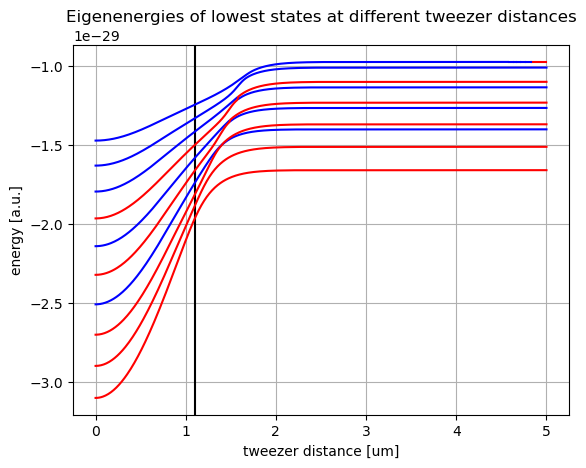

In [178]:
#plot eigenenergies
plt.axvline(float(trap.subs(trap.waist_tweezer1))/si.um, color="black",label="tweezer waist")
for i in range(len(new_energies[0])):
    #differentiate states that are coming from right and left tweezer
    if np.sum(new_states[0,i,:int(new_states.shape[2]/2)]**2) < 0.5:
        plt.plot(distances/si.um,new_energies[:,i],color="red",label=f"state {i}")
    else:
        plt.plot(distances/si.um,new_energies[:,i],color="blue",label=f"state {i}")

plt.title("Eigenenergies of lowest states at different tweezer distances")
plt.xlabel("tweezer distance [um]")
plt.ylabel("energy [a.u.]")
#plt.xlim(1.1,2.7)
#plt.ylim(-4.0e-29,-1.5e-29)

plt.grid()
#plt.legend()
plt.show()

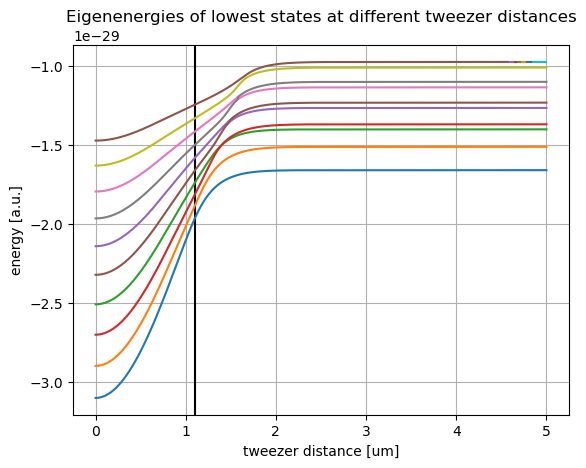

In [179]:
#plot eigenenergies
plt.axvline(float(trap.subs(trap.waist_tweezer1))/si.um, color="black",label="tweezer waist")
for i in range(len(new_energies[0])):
    if np.any(i == np.arange(len(new_energies[0]))[0:20]):
        plt.plot(distances/si.um,new_energies[:,i],label=f"state {i}")

plt.title("Eigenenergies of lowest states at different tweezer distances")
plt.xlabel("tweezer distance [um]")
plt.ylabel("energy [a.u.]")
#plt.xlim(1.1,2.7)
#plt.ylim(-4.0e-29,-1.5e-29)

plt.grid()
#plt.legend()
plt.show()